# Project for UDA Assessment 4
## Author: 02179784 (Mark Roberts)

<B>Project Description:</B><BR>
The objective of this project is to create a simple framework to test how well image classification models perform when presented with noisey images.  The idea is that different models can be swapped-in/out and tested with minimal changes.

In this particular implementation of the framework:
 - we use a model that has been pre-trained to classify non-noisy images with an accurancy of over 97%.<BR>
    This model was created using the guidance provided in chapter 8 of [1], and is based on refining an already pretrained model.<BR>
    The refining of the model has been omitted here as it took several hours to build this model!
 - all images used in the training, validation and testing of this model are cat and dog images taken from the Kaggle website: [Cat and Dog Images](https://kaggle.com/competitions/dogs-vs-cats/data).
 - testing will be done using uniform random noise, but this could be easily replaced by other noise patterns (e.g. Gaussian) if desired.  The image dataset consists of 2000 images - 1000 cat and 1000 dog images.


<B>General Information:</B><BR>
 - This script was run on a Macbook Pro. with 16 GB of RAM, 3.1 GHz Quad-Core Intel Core i7.
 - The total run time of the Jupyter notebook was (approx) 120 seconds.
 - The Github repository for all code and datasets can be obtained by cloning the repository:<BR>
              git@github.com:Mark12481632/UDA_Assessment_4_02179784_Roberts.git
 - The model used to classify the images is built on __TensorFlow__ and __Keras__.
 - __Altered images need to be saved to disk - so write permission for the notebook is required!!__
    
<B>References:</B><BR>
    
    [1] - Deep Learning with Python (Francios Chollet, Manning Publications, ISBN-13: 978-1617296864)

In [1]:
# Start time
import datetime

e = datetime.datetime.now()

print ("Current date and time = %s" % e)

Current date and time = 2022-12-26 17:38:27.212515


In [2]:
# Load in the required libraries

import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import layers, Input, Model, Sequential
from keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory
from skimage import io

2022-12-26 17:38:29.197920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Location of non-noisy and noisy images:
test_dir = "./cats_vs_dogs/test"
test_noisy_dir = "./cats_vs_dogs/test_noisy"

test_dataset = image_dataset_from_directory(test_dir, image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.


2022-12-26 17:38:35.482135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# variable that stores accuracy and level of noise in images
noise_level = []
accuracy = []
sample_image = []

In [5]:
# Test on Original images without any noise.
# The image that was trained has been saved as "feature_extraction_with_data_augmentation.keras"

test_model = load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)

noise_level.append(0)                                          # Noise level saved
accuracy.append(round(test_acc, 4))                            # Model accuracy saved
sample_image.append(io.imread(test_dir + "/cat/cat.1500.jpg")) # Sample image saved

63/63 [==============================] - 156s 2s/step - loss: 3.5702 - accuracy: 0.9755


In [6]:
def create_noisy_image(src_img, dst_img, noise_level):
    """
    This function takes a single image 'src_img' and addes noise to it as defoned
    by the 'noise_level' parameter.  The noisy image is then written to 'dst_img'.
    Nothing is returned.
    """
    # Read in image into Numpy array
    img = io.imread(src_img)

    # Generate a matrix of random data (0=>1) in same shape as image
    noise_matrix = np.random.uniform(low=0, high=1.0,
                                     size=(img.shape[0]*img.shape[1])).reshape(img.shape[0], img.shape[1])
    # Where does the data exceed the "threshold"
    noise_matrix = np.where(noise_matrix < noise_level)

    # Remove colours from image at the given random points
    for (x,y) in zip(noise_matrix[0], noise_matrix[1]):
        img[x, y, 0:3] = 0

    # Save the image
    io.imsave(dst_img, img)


def create_noisy_images(src_dir, dst_dir, noise_level):
    """
    This function copies over the images from a 'src_dir' to a 'dst_dir' after random
    noise has been added to the image.  The 'noise_level' determines the level of noise (0->1).
    Nothing is returned.
    """
    all_cats = os.listdir(src_dir + "/cat")
    all_dogs = os.listdir(src_dir + "/dog")

    for cat in all_cats:
        create_noisy_image(src_dir + "/cat/" + cat, dst_dir + "/cat/" + cat, noise_level)

    for dog in all_dogs:
        create_noisy_image(src_dir + "/dog/" + dog, dst_dir + "/dog/" + dog, noise_level)

In [7]:
# Now we apply the model to varying levels of noise in the image.
# Noise profile - defined noise level at each step - shoul be between 0 and 1.0.
noise_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
                
for lvl in noise_levels:
    print(f"DEBUG: 1. Processing noise level:{lvl}")

    np.random.seed(2179784)  # To ensure reproducible.

    # Step 1: Clear out the ./cats_vs_dogs/test_noisy directories
    os.system('rm ./cats_vs_dogs/test_noisy/cat/*')
    os.system('rm ./cats_vs_dogs/test_noisy/dog/*')

    print("DEBUG: 2. Creating Images")

    # Step 2: Copy over the image after adding noise and setup as dataset
    create_noisy_images(test_dir, test_noisy_dir, lvl)
    test_noisy_dataset = image_dataset_from_directory(test_noisy_dir, image_size=(180, 180), batch_size=32)

    print("DEBUG: 3. Save image")

    # Step 3: Save example image
    sample_image.append(io.imread(test_noisy_dir + "/cat/cat.1500.jpg"))

    print("DEBUG: 4. Running Model")

    # Step 4: Run model against images
    test_loss, test_acc = test_model.evaluate(test_noisy_dataset)

    print("DEBUG: 5. Save Results")

    # Step 5: Save results
    noise_level.append(lvl)              # Noise level saved
    accuracy.append(round(test_acc, 4))  # Model accuracy saved


DEBUG: 1. Processing noise level:0.05
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save image
DEBUG: 4. Running Model
63/63 [==============================] - 160s 3s/step - loss: 13.5091 - accuracy: 0.9185
DEBUG: 5. Save Results
DEBUG: 1. Processing noise level:0.1
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save image
DEBUG: 4. Running Model
63/63 [==============================] - 153s 2s/step - loss: 22.8581 - accuracy: 0.8650
DEBUG: 5. Save Results
DEBUG: 1. Processing noise level:0.15
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save image
DEBUG: 4. Running Model
63/63 [==============================] - 2065s 33s/step - loss: 31.7887 - accuracy: 0.8295
DEBUG: 5. Save Results
DEBUG: 1. Processing noise level:0.2
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save image
DEBUG: 4. Running Model
63/63 [==============================] - 602s 10s/step - loss: 3

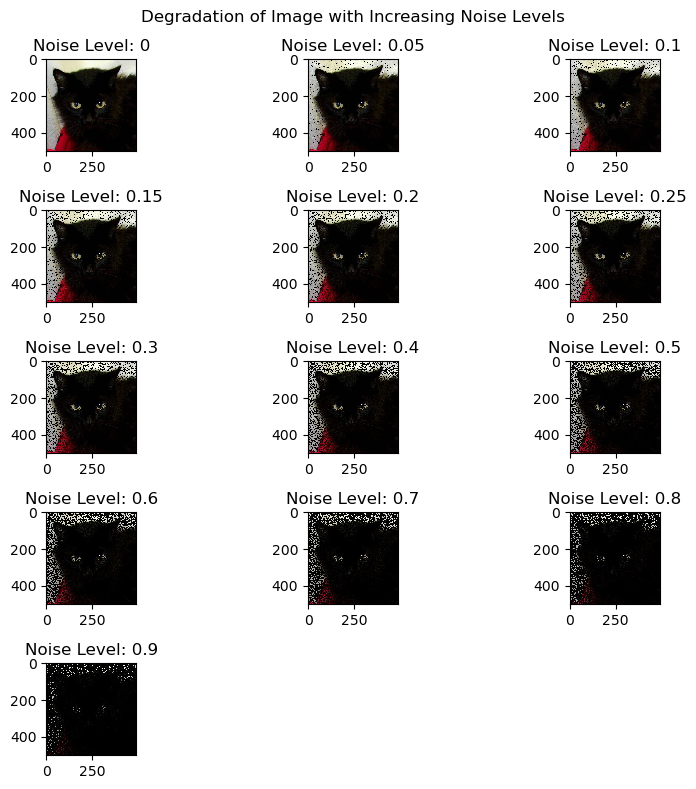

In [14]:
# Display sample images with varying degrees of noise

fig = plt.figure(figsize=(8, 8))
fig.suptitle('Degradation of Image with Increasing Noise Levels')
for i in range(len(sample_image)):
    ax = fig.add_subplot(5, 3, i+1)
    ax.set_title(f"Noise Level: {noise_level[i]}")
    io.imshow(sample_image[i])

Text(0.5, 1.0, 'Model Accuracy Vs. Noise Level')

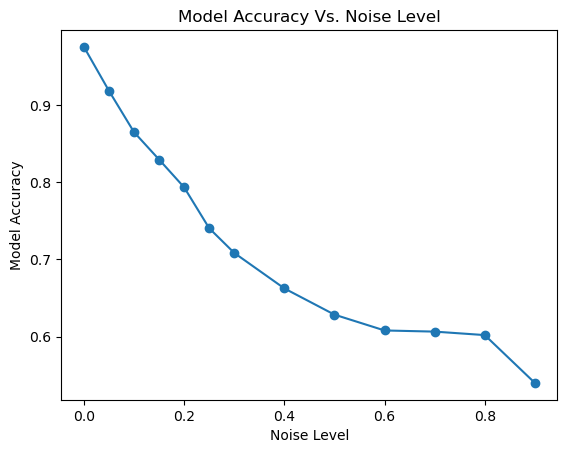

In [9]:
# Display the results of the effect of noise on the model's ability to classify images.

plt.plot(noise_level, accuracy, '-o')
plt.xlabel("Noise Level")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy Vs. Noise Level")

In [10]:
e = datetime.datetime.now()

print ("Current date and time = %s" % e)

Current date and time = 2022-12-26 21:35:42.847806
